In [85]:
# packages

import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import scipy

from scipy.signal import sawtooth, square, savgol_filter
import pandas as pd
import glob as gl
import os
import cmath

from scipy.signal import sawtooth, square,find_peaks, savgol_filter
from scipy import spatial
#import lambdafit as lf
from scipy.interpolate import CubicSpline,interp1d
import h5py

from tqdm import tqdm as tqdm_terminal
from tqdm.notebook import trange, tqdm_notebook
from scipy.signal.windows import hann

from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import curve_fit


# for pandas visual number display 

pd.set_option('display.precision', 6)
pd.set_option('display.float_format', '{:.10f}'.format)

In [3]:

#Functions for reading, processing, and demodulating real data
def read_data(filename, chunk='all', chunk_start=None, chunk_stop=None, single_channel=None):
    # read in file
    file = h5py.File(filename, 'r') 
    # pre-setting range for the for-loop iterating to fix the 0-22 rows of resonator buffer 
    buffer_range_fixed = range(22, (file['time_ordered_data']['adc_i'].shape[0])) 
    # iterate depending on chunk argument 
    if chunk == 'all':
        ch = np.array([channel - 22 for channel in buffer_range_fixed])
        t = np.array(file['time_ordered_data']['timestamp'])
        adc_i = np.array([file['time_ordered_data']['adc_i'][channel] for channel in buffer_range_fixed])
        adc_q = np.array([file['time_ordered_data']['adc_q'][channel] for channel in buffer_range_fixed])
        
    elif chunk == 'some': 
        ch = np.array([channel - 22 for channel in buffer_range_fixed[chunk_start:chunk_stop]])
        t = np.array(file['time_ordered_data']['timestamp'])
        adc_i = np.array([file['time_ordered_data']['adc_i'][channel] for channel in buffer_range_fixed[chunk_start:chunk_stop]])
        adc_q = np.array([file['time_ordered_data']['adc_q'][channel] for channel in buffer_range_fixed[chunk_start:chunk_stop]])
        
    elif chunk == 'single':
        ch = np.array(buffer_range_fixed[single_channel] - 22)
        t = np.array(file['time_ordered_data']['timestamp'])
        adc_i = np.array(file['time_ordered_data']['adc_i'][buffer_range_fixed[single_channel]])
        adc_q = np.array(file['time_ordered_data']['adc_q'][buffer_range_fixed[single_channel]])
                              
    return t, adc_i, adc_q, ch, file # this function will now have 4 outputs instead of 3

In [88]:
ts_f = '/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133/ts_toneinit_fcenter_4250.0_20240308061355_t_20240308062147.hd5'
times_xy = '/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133/beam_map_data_20240308062147.txt'

In [89]:
t_xy = pd.read_csv(times_xy, sep=',')

In [90]:
t_xy

,start,end,x,y
0,1709907709.2978785038,1709907959.6177837849,0,0
1,1709907961.6202144623,1709907965.1014409065,10,0
2,1709907967.1036620140,1709907970.5852940083,20,0
3,1709907972.5858492851,1709907976.0646548271,30,0
4,1709907978.0658402443,1709907981.5459232330,40,0
...,...,...,...,...
5771,1709939586.7333009243,1709939590.2120680809,40,750
5772,1709939592.2142755985,1709939595.6955122948,30,750
5773,1709939597.6966049671,1709939601.1780261993,20,750
5774,1709939603.1804363728,1709939606.6595745087,10,750


In [7]:
# for now, just going to separate them out, later on might be better to have it return a dictionary

t, i, q, ch, file = read_data(ts_f,chunk='some', chunk_start=10, chunk_stop=12)

In [8]:
# trying to find bias line to match up with my channel searching but can't find it... 
file['global_data'].keys()

<KeysViewHDF5 ['attenuator_settings', 'baseband_freqs', 'chan_number', 'chanmask', 'detector_beam_ampl', 'detector_delta_x', 'detector_delta_y', 'detector_dx_dy_elevation_angle', 'detector_pol', 'dfoverf_per_mK', 'ifslice_number', 'lo_freq', 'rfsoc_number', 'sample_rate', 'tile_number', 'tone_powers']>

In [9]:
# look at properties 
print(len(t), len(i), len(q), len(ch))

15578912 2 2 2


In [10]:
stream = i[0] + 1j*q[0]

/home/matt/.local/readout/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


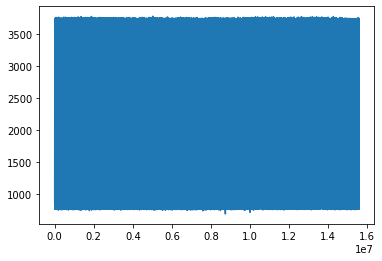

In [11]:
plt.plot(stream)

In [12]:
# array of (t, i, q) for both channels
ch_10 = np.asarray((t, (i[0] + 1j*q[0])))
ch_11 = np.asarray((t, (i[1] + 1j*q[1])))

In [68]:
ch_10[1]

array([ 874.-1174.j, 1004. -300.j, 2125. +641.j, ...,  845.-1215.j,
        976. -345.j, 2099. +675.j])

In [23]:
int(3*len(ch_10[0])/8)

5842092

In [40]:
# breaking into smaller time chunks, just in order to look at smaller bits?
ch10_tchunks = np.asarray(((ch_10[0:int(len(ch_10[0])/4), 0:int(len(ch_10[0])/4)]), 
                          (ch_10[int(len(ch_10[0])/4):int(len(ch_10[0])/2), int(len(ch_10[0])/4):int(len(ch_10[0])/2)]),
                          (ch_10[int(len(ch_10[0])/2):int(3*len(ch_10[0])/4), int(len(ch_10[0])/2):int(3*len(ch_10[0])/4)]),
                          (ch_10[int(3*(len(ch_10[0])/4)):int(len(ch_10[0])), int(3*(len(ch_10[0])/4)):int(len(ch_10[0]))])
                          ))

/tmp/ipykernel_1599515/3190745606.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ch10_tchunks = np.asarray(((ch_10[0:int(len(ch_10[0])/4), 0:int(len(ch_10[0])/4)]),


In [51]:
len(ch_10[0]) == len(ch10_tchunks[0][0])*4

True

In [53]:
%matplotlib qt

ch10_chunk1 = ch10_tchunks[0]

plt.plot(ch10_chunk1[0], ch10_chunk1[1])

/home/matt/.local/readout/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Just playing around with options for time chunking to graph and not break kernel. Now going to work on getting the time table corrected...

In [91]:
t_xy = t_xy.rename(columns={' end':'end'})

In [92]:
#rearranging

# pull out arrays
start_1 = np.array(t_xy['start'])
stop_1 = np.array(t_xy['end'])
# delete first 
start_1_new = np.delete(start_1, 0)
start_1_new = np.pad(start_1_new, (0, 1)) # keep lengths the same
# confirm
print(start_1[0:3])
print(start_1_new[0:3])
print(start_1[1]==start_1_new[0])



[1.70990771e+09 1.70990796e+09 1.70990797e+09]
[1.70990796e+09 1.70990797e+09 1.70990797e+09]
True


In [95]:
# set new columns (switch em)

start_new = stop_1
stop_new = start_1_new 

t_xy_new = t_xy.copy()
t_xy_new['start'] = start_new
t_xy_new['end'] = stop_new

print(t_xy, t_xy_new)


                     start                   end   x    y
0    1709907709.2978785038 1709907959.6177837849   0    0
1    1709907961.6202144623 1709907965.1014409065  10    0
2    1709907967.1036620140 1709907970.5852940083  20    0
3    1709907972.5858492851 1709907976.0646548271  30    0
4    1709907978.0658402443 1709907981.5459232330  40    0
...                    ...                   ...  ..  ...
5771 1709939586.7333009243 1709939590.2120680809  40  750
5772 1709939592.2142755985 1709939595.6955122948  30  750
5773 1709939597.6966049671 1709939601.1780261993  20  750
5774 1709939603.1804363728 1709939606.6595745087  10  750
5775 1709939608.6617915630 1709939612.1427226067   0  750

[5776 rows x 4 columns]                      start                   end   x    y
0    1709907959.6177837849 1709907961.6202144623   0    0
1    1709907965.1014409065 1709907967.1036620140  10    0
2    1709907970.5852940083 1709907972.5858492851  20    0
3    1709907976.0646548271 1709907978.065840244

In [97]:
for i in range(len(t_xy)):
    if t_xy_new['start'][i] != t_xy['end'][i]:
        print(False)


In [101]:
t_xy_new['end'][0]-t_xy_new['start'][0]

2.0024306774139404

In [102]:
times = np.hstack([t_xy_new['start'], t_xy_new['end']])
times

array([1.70990796e+09, 1.70990797e+09, 1.70990797e+09, ...,
       1.70993960e+09, 1.70993961e+09, 0.00000000e+00])

In [106]:
diffs = []

for i in range(len(t_xy_new)):
    diffs.append(t_xy_new['end'][i] - t_xy_new['start'][i])


In [113]:
print('average measurement time: ' + str(np.average(diffs[:-1])))
print('stdev of measurement time: ' + str(np.std(diffs[:-1])))
print('median measurement time: ' + str(np.median(diffs[:-1])))

average measurement time: 2.0021414247735754
stdev of measurement time: 0.00042056351601956295
median measurement time: 2.002235174179077


In [114]:
plt.plot(diffs[:-1])

In [115]:
orig_diffs = []

for i in range(len(t_xy)):
    orig_diffs.append(t_xy['end'][i] - t_xy['start'][i])


In [116]:
print('average measurement time: ' + str(np.average(orig_diffs[:-1])))
print('stdev of measurement time: ' + str(np.std(orig_diffs[:-1])))
print('median measurement time: ' + str(np.median(orig_diffs[:-1])))

average measurement time: 3.5215579541111404
stdev of measurement time: 3.2479096743820297
median measurement time: 3.4783599376678467
